In [1]:
library(data.table)

In [ ]:
## download data files from web
download.file('http://rdatasciencecases.org/Data/offline.final.trace.txt','offline.final.trace.txt', method="curl", quiet=FALSE , mode="w", cacheOK=TRUE)
download.file('http://rdatasciencecases.org/Data/online.final.trace.txt','online.final.trace.txt', method="curl", quiet=FALSE , mode="w", cacheOK=TRUE)

In [11]:
# put it all together to process a line as a function
# note that the if statement handles null values to remove warnings
processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
if (length(tokens) == 10)
  return(NULL)
tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6,
byrow = TRUE), tmp)
}


# create a function that will round off to the nearest major angle
roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}


# re do our data read combining all the anlysis we did here there are 7 SEVEN macids
readData = 
  function(filename = 'offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }


In [12]:
# implement our function
offline = readData()


In [13]:
head(offline)

time,posX,posY,orientation,mac,signal,rawTime,angle
2006-02-11 02:31:58,0,0,0,00:14:bf:b1:97:8a,-38,1.139643e+12,0
2006-02-11 02:31:58,0,0,0,00:14:bf:b1:97:90,-56,1.139643e+12,0
2006-02-11 02:31:58,0,0,0,00:0f:a3:39:e1:c0,-53,1.139643e+12,0
2006-02-11 02:31:58,0,0,0,00:14:bf:b1:97:8d,-65,1.139643e+12,0
2006-02-11 02:31:58,0,0,0,00:14:bf:b1:97:81,-65,1.139643e+12,0
2006-02-11 02:31:58,0,0,0,00:14:bf:3b:c7:c6,-66,1.139643e+12,0


In [14]:
unique(offline$mac)

[1] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:90" "00:0f:a3:39:e1:c0"
[4] "00:14:bf:b1:97:8d" "00:14:bf:b1:97:81" "00:14:bf:3b:c7:c6"
[7] "00:0f:a3:39:dd:cd"

In [15]:
# examine signal strength overall
summary(offline$signal)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -98.00  -67.00  -59.00  -59.92  -53.00  -25.00 

In [16]:
subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81")


In [17]:
#Setup all the data using the data summary
offline$posXY = paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary = do.call("rbind", signalSummary)  

In [18]:
head(offlineSummary)

,time,posX,posY,orientation,mac,signal,rawTime,angle,posXY,medSignal,avgSignal,num,sdSignal,iqrSignal
7,2006-02-11 02:31:58,0,0,0.0,00:0f:a3:39:dd:cd,-75,1.139643e+12,0,0-0,-67,-68.12613,111,3.159739,4.5
24512,2006-02-11 03:03:44,0,1,0.7,00:0f:a3:39:dd:cd,-73,1.139645e+12,0,0-1,-70,-70.33636,110,2.420392,3.0
221777,2006-02-11 06:46:02,0,10,0.9,00:0f:a3:39:dd:cd,-69,1.139658e+12,0,0-10,-67,-69.24324,111,4.407053,6.5
229191,2006-02-11 06:54:05,0,11,0.4,00:0f:a3:39:dd:cd,-72,1.139659e+12,0,0-11,-73,-74.30631,111,5.396620,7.0
236493,2006-02-11 07:02:32,0,12,0.2,00:0f:a3:39:dd:cd,-72,1.139659e+12,0,0-12,-70,-69.57895,114,2.372015,3.0
243546,2006-02-11 07:14:12,0,13,0.1,00:0f:a3:39:dd:cd,-69,1.139660e+12,0,0-13,-74,-73.58716,109,3.493939,4.0


In [19]:
unique(offlineSummary$mac)

[1] "00:0f:a3:39:dd:cd" "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6"
[4] "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d"
[7] "00:14:bf:b1:97:90"

**mac ids that are similar are  :**

"00:0f:a3:39:e1:c0"   
"00:0f:a3:39:dd:cd" 

In [20]:
# here is where we drop a macid
offlineSummary1 = subset(offlineSummary, mac != subMacs[1])
offlineSummary2 = subset(offlineSummary, mac != subMacs[2])

In [21]:
unique(offlineSummary1$mac)
unique(offlineSummary2$mac)

[1] "00:0f:a3:39:dd:cd" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[4] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

[1] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[4] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [22]:
# Look at the access points
# signal strength vs distance

AP1 = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(subMacs[ -1 ], c("x", "y") ))

AP2 = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(subMacs[ -2 ], c("x", "y") ))

AP = matrix( c( 7.5, 6.3, 7.5, 6.3,2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(subMacs, c("x", "y") ))


AP1
AP2
AP

,x,y
00:0f:a3:39:dd:cd,7.5,6.3
00:14:bf:b1:97:8a,2.5,-0.8
00:14:bf:3b:c7:c6,12.8,-2.8
00:14:bf:b1:97:90,1.0,14.0
00:14:bf:b1:97:8d,33.5,9.3
00:14:bf:b1:97:81,33.5,2.8


,x,y
00:0f:a3:39:e1:c0,7.5,6.3
00:14:bf:b1:97:8a,2.5,-0.8
00:14:bf:3b:c7:c6,12.8,-2.8
00:14:bf:b1:97:90,1.0,14.0
00:14:bf:b1:97:8d,33.5,9.3
00:14:bf:b1:97:81,33.5,2.8


,x,y
00:0f:a3:39:e1:c0,7.5,6.3
00:0f:a3:39:dd:cd,7.5,6.3
00:14:bf:b1:97:8a,2.5,-0.8
00:14:bf:3b:c7:c6,12.8,-2.8
00:14:bf:b1:97:90,1.0,14.0
00:14:bf:b1:97:8d,33.5,9.3
00:14:bf:b1:97:81,33.5,2.8


In [24]:
macs1 = subMacs[-1]
macs2 = subMacs[-2]
macs = subMacs

In [37]:
# tally signal strength

#online = readData("online.final.trace.txt", subMacs = macs)
online = readData("online.final.trace.txt")
online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))
head(online)
tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

get_onlineSummary = function(data,include_mac){

    keepVars = c("posXY", "posX","posY", "orientation", "angle")
    online=online[online$mac %in% include_mac,]
    byLoc = with(online, 
                 by(online, list(posXY,angle ), 
                    function(x) {
                      ans = x[1, keepVars]
                      avgSS = tapply(x$signal, x$mac, mean)
                      y = matrix(avgSS, nrow = 1, ncol = length(include_mac),
                            dimnames = list(ans$posXY, names(avgSS)))
                      cbind(ans, y)
                    }))

    onlineSummary = do.call("rbind", byLoc)
    return(onlineSummary)
    }

onlineSummary=get_onlineSummary(online,macs)
onlineSummary1=get_onlineSummary(online,macs1)
onlineSummary2=get_onlineSummary(online,macs2)
head(onlineSummary)
head(onlineSummary1)
head(onlineSummary2)

[1] 60

time,posX,posY,orientation,mac,signal,rawTime,angle,posXY
2006-02-11 16:14:37,0,0.05,130.5,00:14:bf:b1:97:8a,-43,1.139692e+12,135,0-0.05
2006-02-11 16:14:37,0,0.05,130.5,00:0f:a3:39:e1:c0,-52,1.139692e+12,135,0-0.05
2006-02-11 16:14:37,0,0.05,130.5,00:14:bf:3b:c7:c6,-62,1.139692e+12,135,0-0.05
2006-02-11 16:14:37,0,0.05,130.5,00:14:bf:b1:97:81,-58,1.139692e+12,135,0-0.05
2006-02-11 16:14:37,0,0.05,130.5,00:14:bf:b1:97:8d,-62,1.139692e+12,135,0-0.05
2006-02-11 16:14:37,0,0.05,130.5,00:14:bf:b1:97:90,-57,1.139692e+12,135,0-0.05


            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 704   0   0   0   0
  0.15-9.42    0   0 717   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 684   0   0
  0.47-8.2   701   0   0   0   0   0   0   0
  0.78-10.94 695   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 691   0   0   0

,posXY,posX,posY,orientation,angle,00:0f:a3:39:dd:cd,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
5923,0.47-8.2,0.47,8.20,5.8,0,-74.15315,-49.50000,-64.25806,-72.59770,-45.65289,-60.79747,-49.58000
8756,0.78-10.94,0.78,10.94,348.3,0,-71.40367,-53.26364,-66.96000,-66.80952,-48.41379,-65.00000,-54.84694
22032,1.52-9.32,1.52,9.32,7.0,0,-65.38318,-50.36697,-63.35922,-67.48913,-50.04167,-65.10345,-49.38542
19504,12.55-7.38,12.55,7.38,20.9,0,-59.17273,-41.66972,-52.32941,-58.08791,-62.24038,-51.67327,-68.34940
45746,23.24-7.5,23.24,7.50,7.9,0,-79.59259,-56.48182,-59.52874,-53.79348,-65.22772,-56.66316,-69.67391
34679,23.9-7,23.90,7.00,344.9,0,-78.04762,-57.51852,-61.65556,-54.16495,-64.83333,-58.33735,-69.24468


,posXY,posX,posY,orientation,angle,00:0f:a3:39:dd:cd,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
5923,0.47-8.2,0.47,8.20,5.8,0,-74.15315,-64.25806,-72.59770,-45.65289,-60.79747,-49.58000
8756,0.78-10.94,0.78,10.94,348.3,0,-71.40367,-66.96000,-66.80952,-48.41379,-65.00000,-54.84694
22032,1.52-9.32,1.52,9.32,7.0,0,-65.38318,-63.35922,-67.48913,-50.04167,-65.10345,-49.38542
19505,12.55-7.38,12.55,7.38,20.9,0,-59.17273,-52.32941,-58.08791,-62.24038,-51.67327,-68.34940
45746,23.24-7.5,23.24,7.50,7.9,0,-79.59259,-59.52874,-53.79348,-65.22772,-56.66316,-69.67391
34679,23.9-7,23.90,7.00,344.9,0,-78.04762,-61.65556,-54.16495,-64.83333,-58.33735,-69.24468


,posXY,posX,posY,orientation,angle,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
5923,0.47-8.2,0.47,8.20,5.8,0,-49.50000,-64.25806,-72.59770,-45.65289,-60.79747,-49.58000
8756,0.78-10.94,0.78,10.94,348.3,0,-53.26364,-66.96000,-66.80952,-48.41379,-65.00000,-54.84694
22032,1.52-9.32,1.52,9.32,7.0,0,-50.36697,-63.35922,-67.48913,-50.04167,-65.10345,-49.38542
19504,12.55-7.38,12.55,7.38,20.9,0,-41.66972,-52.32941,-58.08791,-62.24038,-51.67327,-68.34940
45746,23.24-7.5,23.24,7.50,7.9,0,-56.48182,-59.52874,-53.79348,-65.22772,-56.66316,-69.67391
34679,23.9-7,23.90,7.00,344.9,0,-57.51852,-61.65556,-54.16495,-64.83333,-58.33735,-69.24468


In [41]:
length(onlineSummary2$posXY)

[1] 60

In [27]:
head(online)

time,posX,posY,orientation,mac,signal,rawTime,angle,posXY
2006-02-11 16:14:37,0,0.05,130.5,00:14:bf:b1:97:8a,-43,1.139692e+12,135,0-0.05
2006-02-11 16:14:37,0,0.05,130.5,00:0f:a3:39:e1:c0,-52,1.139692e+12,135,0-0.05
2006-02-11 16:14:37,0,0.05,130.5,00:14:bf:3b:c7:c6,-62,1.139692e+12,135,0-0.05
2006-02-11 16:14:37,0,0.05,130.5,00:14:bf:b1:97:81,-58,1.139692e+12,135,0-0.05
2006-02-11 16:14:37,0,0.05,130.5,00:14:bf:b1:97:8d,-62,1.139692e+12,135,0-0.05
2006-02-11 16:14:37,0,0.05,130.5,00:14:bf:b1:97:90,-57,1.139692e+12,135,0-0.05


In [18]:
length(unique(online$posXY))
length(unique(online$posXY,online$angle))

[1] 60

[1] 60

In [114]:
# create data frame and functions to aggregate/select data with similar angles
# including from training dataset only those observations that were recorded in 45 degree increments 
# that are 'm' nearest to the observation we are interested in

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  num_macs=length(unique(data$mac))
 

    byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = num_macs,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}


#trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal",7)

selectTrain = function(angleNewObs,  signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1){ 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  } else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] =     angles[ angles > 360 ] - 360
  angles = sort(angles) 

  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

train130 = selectTrain(130, offlineSummary, m = 3)

head(train130)

length(train130[[1]])

,posXY,posX,posY,00:0f:a3:39:dd:cd,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,-71.76555,-52.37243,-66.13039,-63.19262,-35.58063,-64.25411,-55.33780
0-1,0-1,0,1,-70.47375,-52.98182,-65.37177,-63.72941,-39.37649,-65.44867,-59.15328
0-10,0-10,0,10,-70.12946,-56.34184,-65.67238,-69.16041,-44.71545,-66.85781,-50.45502
0-11,0-11,0,11,-70.62604,-54.73420,-67.17593,-70.34538,-48.34689,-66.78383,-54.93054
0-12,0-12,0,12,-68.84840,-56.03030,-70.46493,-72.28758,-45.17264,-66.72696,-50.49886
0-13,0-13,0,13,-73.49886,-54.55152,-71.19211,-72.58496,-43.32784,-68.72616,-54.48160


[1] 166

In [223]:
# here is our NN function.
findNN = function(newSignal, trainSubset,num_macs) {
  num_cols=3+num_macs

  diffs = apply(trainSubset[ , 4:num_cols], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )

  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}
                


In [230]:
# predict X-Y based on the the neasest k neighbors (default 3)
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  num_macs=ncol(newSignals)

  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
#      if(i==1) {
#      print("trainSS")
 #     print(trainSS)}
    closeXY[[i]] = 
      #findNN(newSignal = as.numeric(newSignals[i, ]), trainSS,num_macs)
      findweightedNN(newSignal = as.numeric(newSignals[i, ]), trainSS,num_macs)
 #     if(i==1) {
#          print("closeXY")
#    print(closeXY[[i]])
#      print("====")}
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  print("estXY")
                                    print(estXY)
                                    estXY = do.call("rbind", estXY)
  return(estXY)
#return(closeXY)
}
                                    

                                    
# nearest 3 neighbors                                    
                                    
estXY2k3 = predXY(newSignals = onlineSummary2[ , 6:11], 
                 newAngles = onlineSummary2[ , 4], 
                 offlineSummary2, numAngles = 3, k = 3)

# nearest neighbor
estXY2k1= predXY(newSignals = onlineSummary2[ , 6:11], 
                 newAngles = onlineSummary2[ , 4], 
                 offlineSummary2, numAngles = 3, k = 1)
estXY2k3
estXY2k1

[1] "estXY"
$length
    posX     posY 
1.333333 7.000000 

[[2]]
posX posY 
   1    9 

[[3]]
    posX     posY 
2.333333 9.000000 

[[4]]
    posX     posY 
10.66667  7.00000 

[[5]]
     posX      posY 
21.333333  4.666667 

[[6]]
     posX      posY 
21.333333  4.666667 

[[7]]
    posX     posY 
28.33333  8.00000 

[[8]]
    posX     posY 
6.666667 7.666667 

[[9]]
    posX     posY 
9.333333 7.666667 

[[10]]
    posX     posY 
9.333333 5.666667 

[[11]]
posX posY 
  12    3 

[[12]]
     posX      posY 
25.000000  7.333333 

[[13]]
    posX     posY 
5.333333 7.333333 

[[14]]
     posX      posY 
27.000000  6.666667 

[[15]]
     posX      posY 
 1.666667 11.666667 

[[16]]
    posX     posY 
1.333333 2.333333 

[[17]]
     posX      posY 
11.666667  4.666667 

[[18]]
     posX      posY 
12.666667  5.666667 

[[19]]
posX posY 
  13    7 

[[20]]
     posX      posY 
18.000000  7.666667 

[[21]]
     posX      posY 
0.6666667 7.3333333 

[[22]]
    posX     posY 
24.33333  7.000

,posX,posY
length,1.3333333,7.000000
,1.0000000,9.000000
,2.3333333,9.000000
,10.6666667,7.000000
,21.3333333,4.666667
,21.3333333,4.666667
,28.3333333,8.000000
,6.6666667,7.666667
,9.3333333,7.666667
,9.3333333,5.666667


,posX,posY
length,1,11
,0,9
,2,9
,13,7
,16,3
,16,3
,27,8
,7,8
,9,8
,10,6


In [140]:
head(onlineSummary2[ , 6:11])
head(offlineSummary2[ , 4:9])
trainSS_test = selectTrain(onlineSummary2[1 , 4], offlineSummary2, m = 3)
trainSS_test

,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
5923,-49.50000,-64.25806,-72.59770,-45.65289,-60.79747,-49.58000
8756,-53.26364,-66.96000,-66.80952,-48.41379,-65.00000,-54.84694
22032,-50.36697,-63.35922,-67.48913,-50.04167,-65.10345,-49.38542
19504,-41.66972,-52.32941,-58.08791,-62.24038,-51.67327,-68.34940
45746,-56.48182,-59.52874,-53.79348,-65.22772,-56.66316,-69.67391
34679,-57.51852,-61.65556,-54.16495,-64.83333,-58.33735,-69.24468


,orientation,mac,signal,rawTime,angle,posXY
3,0.0,00:0f:a3:39:e1:c0,-53,1.139643e+12,0,0-0
24507,0.7,00:0f:a3:39:e1:c0,-49,1.139645e+12,0,0-1
221774,0.9,00:0f:a3:39:e1:c0,-53,1.139658e+12,0,0-10
229185,0.4,00:0f:a3:39:e1:c0,-53,1.139659e+12,0,0-11
236489,0.2,00:0f:a3:39:e1:c0,-54,1.139659e+12,0,0-12
243539,0.1,00:0f:a3:39:e1:c0,-57,1.139660e+12,0,0-13


,posXY,posX,posY,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,-53.80909,-66.10015,-64.88307,-43.07095,-68.01921,-57.39835
0-1,0-1,0,1,-52.58485,-67.82385,-67.84945,-40.89577,-64.97821,-58.25200
0-10,0-10,0,10,-54.80303,-65.65221,-63.99890,-46.10258,-64.95067,-51.51073
0-11,0-11,0,11,-53.40909,-69.48721,-70.81912,-46.68712,-66.34147,-55.88612
0-12,0-12,0,12,-53.29697,-68.00955,-70.65218,-47.29387,-67.26360,-54.84701
0-13,0-13,0,13,-55.96972,-70.67903,-71.44749,-45.11767,-67.79659,-54.79282
0-2,0-2,0,2,-56.19697,-62.31695,-62.87053,-44.40242,-65.43575,-57.22069
0-3,0-3,0,3,-54.18788,-62.54893,-57.82939,-42.69756,-61.27651,-53.55394
0-4,0-4,0,4,-50.28173,-64.54059,-59.43641,-44.30368,-64.63004,-56.23599
0-7,0-7,0,7,-57.68835,-63.48006,-64.04872,-47.16842,-54.47091,-57.20386


In [141]:
t=findNN(newSignal = as.numeric(onlineSummary2[1 , 6:11]), trainSS_test,6)
t

,posXY,posX,posY
5-8,5-8,5,8
5-7,5-7,5,7
6-8,6-8,6,8
4-8,4-8,4,8
7-8,7-8,7,8
2-2,2-2,2,2
4-7,4-7,4,7
0-4,0-4,0,4
4-3,4-3,4,3
8-8,8-8,8,8


In [102]:
# nearest 3 neighbors                                    
'''                                    
estXYk3 = predXY(newSignals = onlineSummary[ , 6:12], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

# nearest neighbor
estXYk1= predXY(newSignals = onlineSummary[ , 6:12], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)
                                    
                                    # nearest 3 neighbors                                    
                                    
estXY1k3 = predXY(newSignals = onlineSummary1[ , 6:11], 
                 newAngles = onlineSummary1[ , 4], 
                 offlineSummary1, numAngles = 3, k = 3)

# nearest neighbor
estXY1k1= predXY(newSignals = onlineSummary1[ , 6:11], 
                 newAngles = onlineSummary1[ , 4], 
                 offlineSummary1, numAngles = 3, k = 1)
                                    
'''

,posXY,posX,posY,orientation,angle,00:0f:a3:39:dd:cd,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
5923,0.47-8.2,0.47,8.20,5.8,0,-74.15315,-49.50000,-64.25806,-72.59770,-45.65289,-60.79747,-49.58000
8756,0.78-10.94,0.78,10.94,348.3,0,-71.40367,-53.26364,-66.96000,-66.80952,-48.41379,-65.00000,-54.84694
22032,1.52-9.32,1.52,9.32,7.0,0,-65.38318,-50.36697,-63.35922,-67.48913,-50.04167,-65.10345,-49.38542
19504,12.55-7.38,12.55,7.38,20.9,0,-59.17273,-41.66972,-52.32941,-58.08791,-62.24038,-51.67327,-68.34940
45746,23.24-7.5,23.24,7.50,7.9,0,-79.59259,-56.48182,-59.52874,-53.79348,-65.22772,-56.66316,-69.67391
34679,23.9-7,23.90,7.00,344.9,0,-78.04762,-57.51852,-61.65556,-54.16495,-64.83333,-58.33735,-69.24468


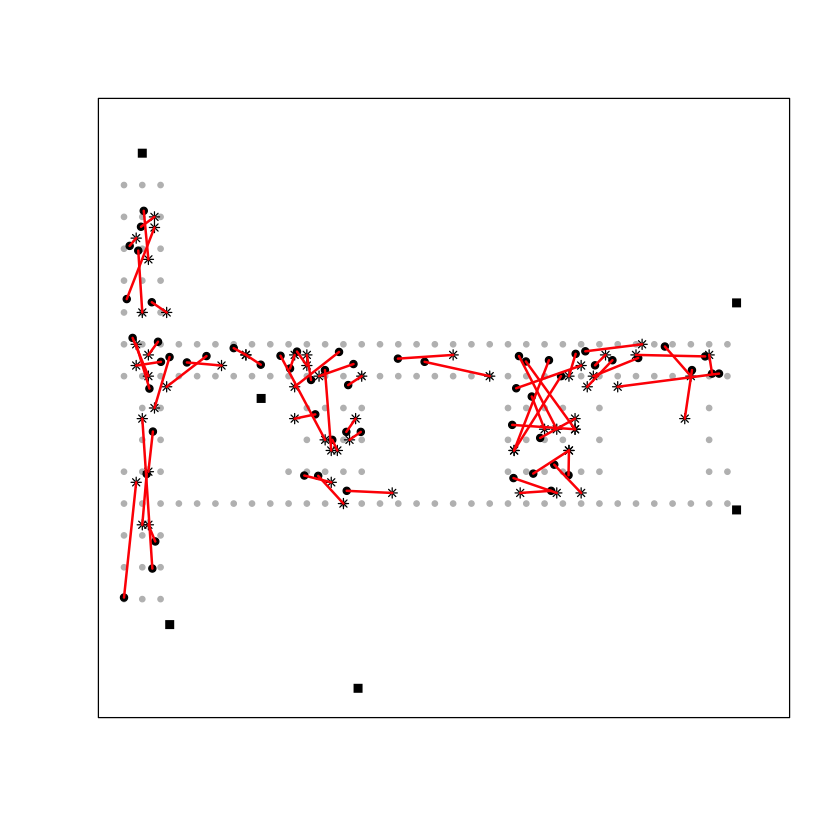

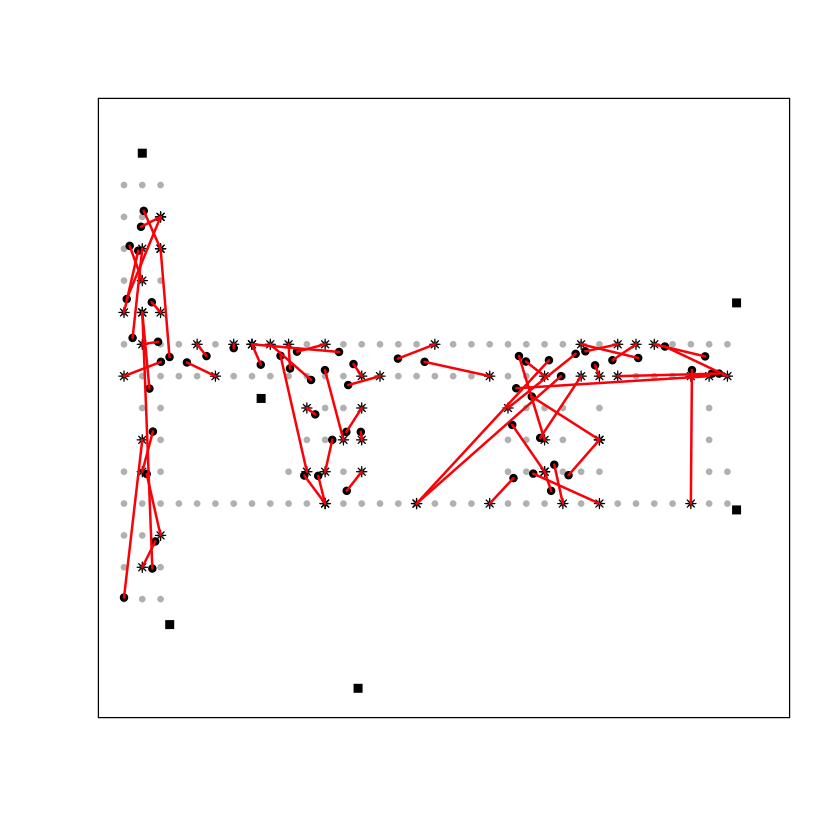

In [157]:
# predict and map errors
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

trainPoints2 = offlineSummary2[ offlineSummary2$angle == 0 & 
                              offlineSummary2$mac == "00:0f:a3:39:e1:c0" ,
                        c("posX", "posY")]

# 3 NN

floorErrorMap(estXY2k3, onlineSummary2[ , c("posX","posY")], 
              trainPoints = trainPoints2, AP = AP2)


# 1 NN
floorErrorMap(estXY2k1, onlineSummary2[ , c("posX","posY")], 
              trainPoints = trainPoints2, AP = AP2)



In [158]:

options(error = recover, warn = 1)
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )


reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
 num_macs=length(unique(data$mac))
    byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = num_macs,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}



ERROR: Error in lapply(X = X, FUN = FUN, ...): object 'estXYk1' not found


[1] 96.33333

[1] 417.1843

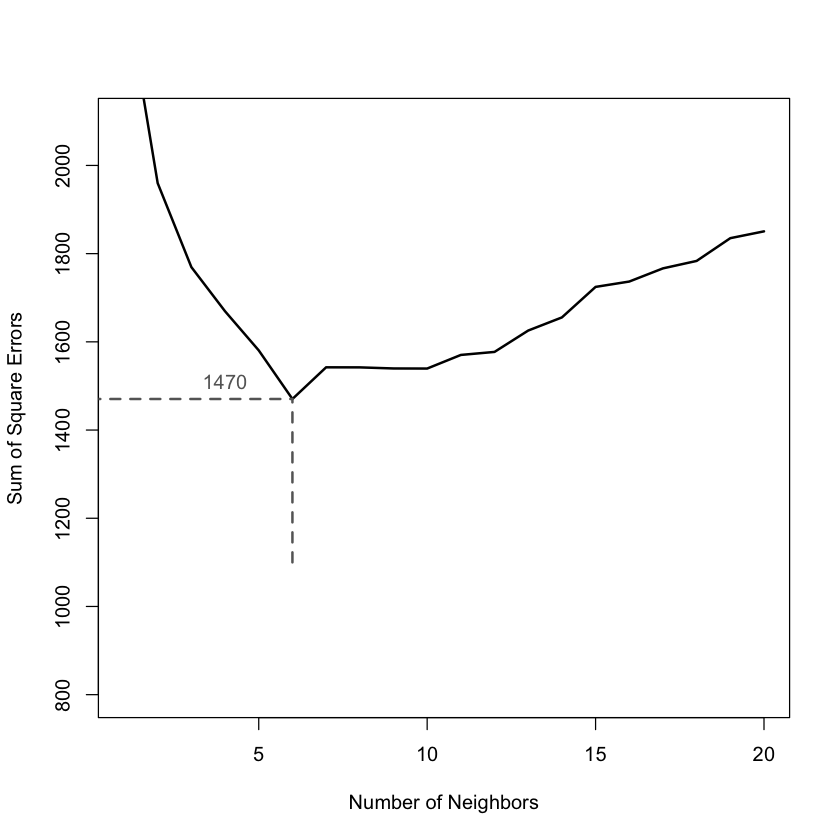

In [29]:
# up to 20 neighbors, 11 folds
# this one can run for a while (5-10 mins)
# this cell and the next are the same, but the angles change slightly!!
#offline1 = offline[ offline$mac != "00:0f:a3:39:e1:c0", ]
#offline2 = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

cvfold_calcerror = function
keepVars = c("posXY", "posX","posY", "orientation", "angle")

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXY2k1, estXY2k3), calcError, actualXY)
v2 = length(onlineSummary)
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

onlineCVSummary = reshapeSS(offline2, keepVars = keepVars, 
                            sampleAngle = TRUE)

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 1, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 1, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}


plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(800, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))


estXYk5 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 1, k = 5)

calcError(estXYk5, actualXY)



[1] 11

[1] 74.55556

[1] 275.5083

[1] 275.5083


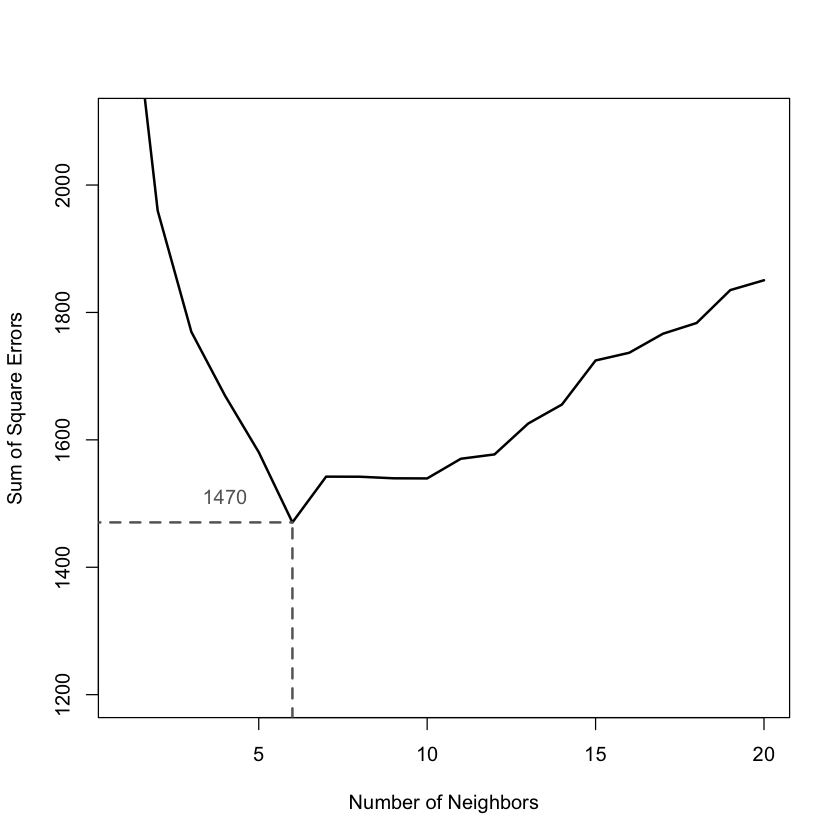

In [30]:
onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 1, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}


plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(1200, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))


estXYk5 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 5)

calcError(estXYk5, actualXY)
print(calcError(estXYk5, actualXY))


### Weighted Neighbours

In [229]:
# here is our NN function.
findweightedNN = function(newSignal, trainSubset,num_macs) {
  num_cols=3+num_macs
#    print("traindataset")
#    print(head(trainSubset[ , 4:num_cols]))
  diffs = apply(trainSubset[ , 4:num_cols], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  #print("dists")
 # print(typeof(dists))
 #               print(dim(dists))
  closest = order(dists)

                odists=dists[closest]
 
                otrainSubset=trainSubset[closest, 1:3 ]
 #               wposX=otrainSubset[,2]*(1/odists)
 #               wposY=otrainSubset[,3]*(1/odists)
#                print("train")
#                print(otrainSubset[,3])
#                print("odists")
#                print(1/odists)
#                print("wposY")
#                print(wposY)
  return(cbind(otrainSubset,1/odists))
}

In [231]:
# predict X-Y based on the the neasest k neighbors (default 3)
predweightedXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  num_macs=ncol(newSignals)

  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
#      if(i==1) {
#      print("trainSS")
 #     print(trainSS)}
    closeXY[[i]] = 
      #findNN(newSignal = as.numeric(newSignals[i, ]), trainSS,num_macs)
      findweightedNN(newSignal = as.numeric(newSignals[i, ]), trainSS,num_macs)
 #     if(i==1) {
#          print("closeXY")
#    print(closeXY[[i]])
#      print("====")}
  }

    odist_upd = lapply(closeXY, function(x) sapply(x[,4], function(x) x/sum(x[1:k])))
                                                   print("odist_upd")
                                                   print(odist_upd)
    estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k]*odist_upd)))
  estXY = do.call("rbind", estXY)
  return(estXY)
#return(closeXY)
}
                                    

                                    
# nearest 3 neighbors                                    
                                    
westXY2k3 = predweightedXY(newSignals = onlineSummary2[ , 6:11], 
                 newAngles = onlineSummary2[ , 4], 
                 offlineSummary2, numAngles = 3, k = 3)

# nearest neighbor
westXY2k1= predweightedXY(newSignals = onlineSummary2[ , 6:11], 
                 newAngles = onlineSummary2[ , 4], 
                 offlineSummary2, numAngles = 3, k = 1)
westXY2k3
westXY2k1

[1] "odist_upd"
$length
  [1] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
 [26] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
 [51] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
 [76] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
[101] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
[126] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
[151] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA

[[2]]
  [1] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
 [26] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
 [51] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
 [76] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
[101] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
[126] NA NA NA NA NA NA 

ERROR: Error in x[1:k] * odist_upd: non-numeric argument to binary operator


In [ ]:
trainPoints2 = offlineSummary2[ offlineSummary2$angle == 0 & 
                              offlineSummary2$mac == "00:0f:a3:39:e1:c0" ,
                        c("posX", "posY")]

# 3 NN

floorErrorMap(westXY2k3, onlineSummary2[ , c("posX","posY")], 
              trainPoints = trainPoints2, AP = AP2)


# 1 NN
floorErrorMap(westXY2k1, onlineSummary2[ , c("posX","posY")], 
              trainPoints = trainPoints2, AP = AP2)

